euclidean  | K= 1 | Acc=0.528 | F1=0.352
euclidean  | K= 3 | Acc=0.525 | F1=0.323
euclidean  | K= 5 | Acc=0.531 | F1=0.288
euclidean  | K= 7 | Acc=0.545 | F1=0.305
euclidean  | K= 9 | Acc=0.538 | F1=0.283
euclidean  | K=11 | Acc=0.545 | F1=0.242
euclidean  | K=13 | Acc=0.531 | F1=0.229
euclidean  | K=15 | Acc=0.554 | F1=0.249
euclidean  | K=17 | Acc=0.568 | F1=0.257
euclidean  | K=19 | Acc=0.571 | F1=0.255
euclidean  | K=21 | Acc=0.581 | F1=0.273
euclidean  | K=23 | Acc=0.588 | F1=0.281
euclidean  | K=25 | Acc=0.571 | F1=0.262
euclidean  | K=27 | Acc=0.574 | F1=0.264
euclidean  | K=29 | Acc=0.588 | F1=0.284
euclidean  | K=31 | Acc=0.574 | F1=0.264
euclidean  | K=33 | Acc=0.581 | F1=0.265
euclidean  | K=35 | Acc=0.581 | F1=0.258
euclidean  | K=37 | Acc=0.578 | F1=0.260
euclidean  | K=39 | Acc=0.574 | F1=0.253
euclidean  | K=41 | Acc=0.584 | F1=0.270
euclidean  | K=43 | Acc=0.584 | F1=0.270
euclidean  | K=45 | Acc=0.574 | F1=0.252
euclidean  | K=47 | Acc=0.588 | F1=0.268
euclidean  | K=4

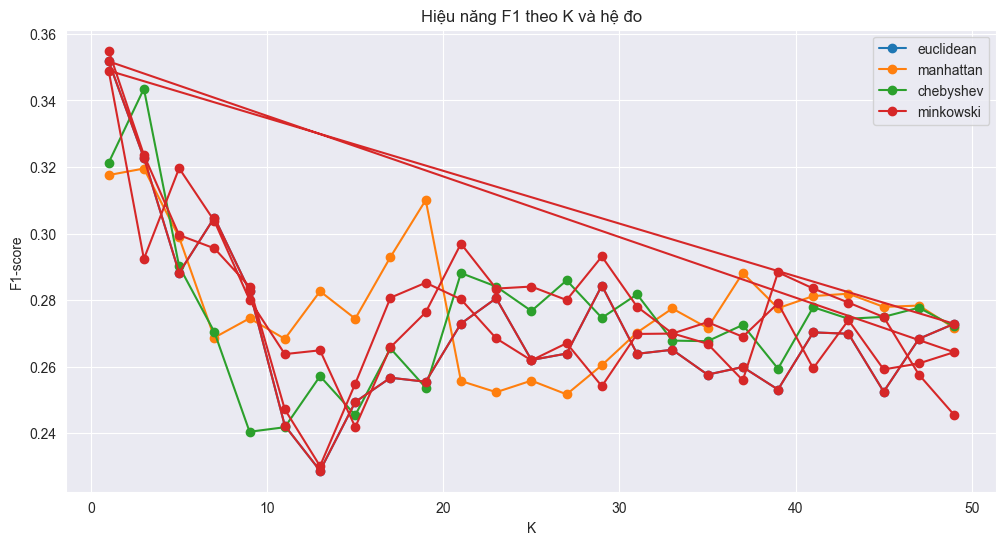

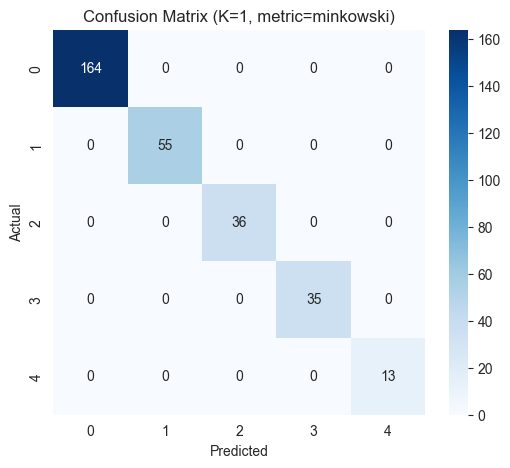

In [13]:

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)
import sys
sys.path.append(r"C:\knn\KNN_HAMIC\src")
from knn_model import knn_predict_classification,knn_predict_proba

# Load data
df =pd.read_csv(r"C:\knn\KNN_HAMIC\data\cleaned_data.csv")
X = df.drop(columns=["target"]).values
y = df["target"].values

# Cross-Validation Evaluation Function
"""
Đánh giá xem KNN với K, metric, p có phù hợp hay không
Tính các độ đo: Accuracy – Precision – Recall – F1
Lấy trung bình trên nhiều lần chia dữ liệu (K-fold)
"""
def evaluate_knn_cv(
    X, y, K, metric, p=None, weights="distance", folds=5, zero_division=0
):
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    acc_list, prec_list, rec_list, f1_list = [], [], [], []

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        y_pred = knn_predict_classification(
            X_train, y_train,
            X_val,
            k=K,
            metric=metric,
            weights=weights,
            p=p if p is not None else 2
        )

        acc_list.append(accuracy_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred, average="macro", zero_division=zero_division))
        rec_list.append(recall_score(y_val, y_pred, average="macro", zero_division=zero_division))
        f1_list.append(f1_score(y_val, y_pred, average="macro", zero_division=zero_division))

    return (
        np.mean(acc_list),
        np.mean(prec_list),
        np.mean(rec_list),
        np.mean(f1_list)
    )

K_values = list(range(1, 50, 2))  # {1,3,5,...,49}
metrics = ["euclidean", "manhattan", "chebyshev"]
minkowski_ps = [1.5, 2, 3]

results = []
# Chạy Grid Search
"""metric thường"""
for metric in metrics:
    for K in K_values:
        acc, prec, rec, f1 = evaluate_knn_cv(
            X, y, K, metric, p=None, weights="distance"
        )
        results.append({
            "K": K,
            "metric": metric,
            "p": None,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })
        print(f"{metric:10} | K={K:2} | Acc={acc:.3f} | F1={f1:.3f}")

""""Minkowski"""
for p in minkowski_ps:
    for K in K_values:
        acc, prec, rec, f1 = evaluate_knn_cv(
            X, y, K, metric="minkowski", p=p, weights="distance"
        )
        results.append({
            "K": K,
            "metric": "minkowski",
            "p": p,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })
        print(f"Minkowski(p={p}) | K={K:2} | Acc={acc:.3f} | F1={f1:.3f}")

#Lưu kết quả vào DataFrame
results_df = pd.DataFrame(results)
results_df.head()

# Chọn cấu hình tối ưu (ưu tiên F1, nếu hòa → K nhỏ hơn)
best_row = results_df.sort_values(
    by=["f1", "K"],
    ascending=[False, True]
).iloc[0]
best_row

# Lưu best_config.json
best_config = {
    "K": int(best_row["K"]),
    "metric": best_row["metric"],
    "p": None if pd.isna(best_row["p"]) else float(best_row["p"]),
    "weights": "distance"
}

with open("best_config.json", "w") as f:
    json.dump(best_config, f, indent=4)

best_config

#Vẽ biểu đồ hiệu năng theo K cho từng metric
plt.figure(figsize=(12, 6))

for metric in results_df["metric"].unique():
    subset = results_df[results_df["metric"] == metric]
    plt.plot(subset["K"], subset["f1"], marker="o", label=metric)

plt.title("Hiệu năng F1 theo K và hệ đo")
plt.xlabel("K")
plt.ylabel("F1-score")
plt.grid(True)
plt.legend()
plt.savefig(r"C:\knn\KNN_HAMIC\data\figures\knn_f1_by_K.png")
plt.show()

#Confusion Matrix với cấu hình tối ưu
best_K = best_config["K"]
best_metric = best_config["metric"]
best_p = best_config["p"]

y_pred = knn_predict_classification(
    X_train=X, y_train=y,
    X_test=X,
    k=best_K,
    metric=best_metric,
    weights="distance",
    p=best_p if best_p else 2
)

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title(f"Confusion Matrix (K={best_K}, metric={best_metric})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(r"C:\knn\KNN_HAMIC\data\figures\Confusion Matrix.png")
plt.show()




